<a href="https://colab.research.google.com/github/YasudaKaito/introduction_llm/blob/main/ch5/ch5_3_sentiment_analysis_error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets transformers[ja,torch] matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 51.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 

In [ ]:
from transformers import pipeline

model_name = "ykit/bert-base-japanese-v3-wrime-sentiment"
sentiment_pipeline = pipeline(model=model_name, device="cuda:0")

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
from datasets import load_dataset

valid_dataset = load_dataset(
    "llm-book/wrime-sentiment",
    split="validation"
)

Generating train split:   0%|          | 0/20149 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1608 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1781 [00:00<?, ? examples/s]

In [4]:
from tqdm import tqdm

class_label = valid_dataset.features["label"]

results: list[dict[str, float | str]] = []
for i, example in tqdm(enumerate(valid_dataset)):
    model_prediction = sentiment_pipeline(example["sentence"])[0]
    # 正解のラベルIDをラベル名に変換
    true_label = class_label.int2str(example["label"])

    results.append(
        {
            "example_id": i,
            "pred_prob": model_prediction["score"],
            "pred_label": model_prediction["label"],
            "true_label": true_label,
        }
    )

10it [00:02,  8.48it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
1608it [00:32, 48.77it/s]


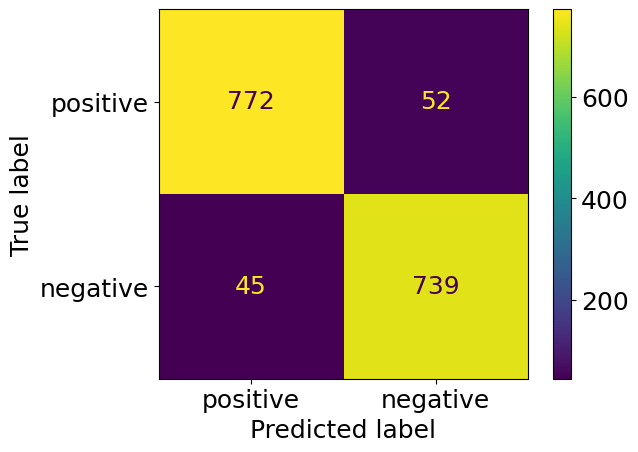

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

plt.rcParams["font.size"] = 18

confusion_matrix = confusion_matrix(
    y_true=[result["true_label"] for result in results],
    y_pred=[result["pred_label"] for result in results],
    labels=class_label.names,
)

# 混同行列を画像表示
ConfusionMatrixDisplay(
    confusion_matrix,
    display_labels=class_label.names,
).plot()

In [9]:
### モデルが自信をもってラベルを予測したにも関わらず、間違えた事例を観察 ###
# 収集
failed_results = [
    r for r in results if r["pred_label"] != r["true_label"]
]
# モデルが誤ったデータについて、予測確率が大きい順にソート
# sorted はデフォルトascending（小さいものが先）
# マイナスをつけることで例えば -0.9, -0.8, -0.7, ... といった順番になる
# reverse=True じゃだめなのか
sorted_failed_results = sorted(
    failed_results,
    key=lambda x: -x["pred_prob"],
)
# 上位5件
for top_result in sorted_failed_results[:5]:
    review_text = valid_dataset[top_result["example_id"]]["sentence"]
    print(f"ツイート：{review_text}")
    print(f"予測：{top_result['pred_label']}")
    print(f"正解：{top_result['true_label']}")
    print(f"予測確率：{top_result['pred_prob']:.4f}")
    print("------------")

ツイート：できれば今すぐお線香あげにいきたい
予測：positive
正解：negative
予測確率：0.9986
------------
ツイート：一月ぶりに湯らっくす行って、10時間も寛いでいまい、寝落ちする以外なにもできない
予測：negative
正解：positive
予測確率：0.9983
------------
ツイート：酒はぬるめの 燗がいい 肴は炙った イカでいい←もっといいもの食えよ
予測：positive
正解：negative
予測確率：0.9981
------------
ツイート：もうwwww訳がwwwwわからないよwwww
予測：negative
正解：positive
予測確率：0.9979
------------
ツイート：というか私のオタク人生に大きな影響を与えすぎたのがクロウ
予測：negative
正解：positive
予測確率：0.9975
------------
